### Interactive Testing
Some interactive "sanity check" scripts to verify things are working.

In [8]:
# Attempt to train on generated data.

import ann
import layers
import numpy as np
net = ann.mlp(InputSize = 10, HiddenSizes = [8,4])

# have to append a final FC, 
# since the mlp helper adds a final relu, 
# probably better to have an option to not do that...
net.layers.append(layers.fc(InputSize=4, NumHidden = 2)) 

# create fake data
xs = []
ys = []

numdata = 2000
for i in range(numdata):
    x = 10*np.random.random(size = (10,1))-5
    xs.append(x)
    
    # y = (|x|^2, 2|x|+1)
    y1 = np.linalg.norm(x, ord = 2) 
    y2 = 2*np.linalg.norm(x, ord = 1)+1
    y = np.expand_dims(np.array([y1, y2]),-1)
    ys.append(y)
    
# split into train/test data
xtrain = xs[1:numdata//2]
ytrain = ys[1:numdata//2]
xtest = xs[numdata//2:]
ytest = ys[numdata//2:]

# Initialize the weights
net.initialize_training_parameters()

# loss function
loss = layers.mse()

# define training iteration
# Basic SGD is built into the ann_by_layers class.
# Not super flexible...
def train(net, xs, ys, iters, step=0.01):
    for iter in range(iters):
        x = xs[iter%len(xs)]
        y = ys[iter%len(ys)]
        updates = net.backprop_updates(x,y,loss,lr = step)
        net.update_training_parameters(updates)

# Define the loss of the network with inputs xs and target ys.
def error(net, xs, ys):
    e = 0
    for x,y in zip(xs, ys):
        z = net.forward(x)        
        squareError = np.sum(np.power(y-z,2))
        e = e+squareError
    e = e/len(xs)
    e = np.sqrt(e)
    return e


testErrors = []
for i in range(100):
    iters = 10
    index = np.random.randint(0,500-iters)
    train(net, xtrain[index:(index+iters)], ytrain[index:(index+iters)],iters)
    e = error(net, xtest, ytest)
    testErrors.append(e)

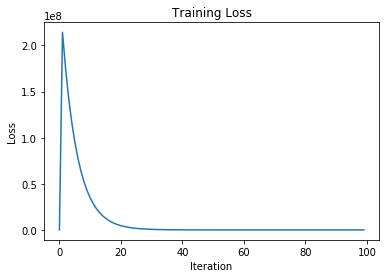

In [9]:
import matplotlib.pyplot as plt
plt.plot(testErrors)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()